In [1]:
import dataclasses

import corner
import emcee
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

from cr_knee_fit.fit_data import FitData
from cr_knee_fit.inference import make_loglikelihood, make_logposterior
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.types_ import Experiment, Primary

In [2]:
from cr_knee_fit.cr_model import CosmicRaysModelConfig

EXPERIMENTS = list(Experiment)

config = ModelConfig(
    cr_model_config=CosmicRaysModelConfig(
        components=[
            [Primary.H],
            [Primary.He],
            sorted(p for p in Primary if p not in {Primary.H, Primary.He}),
        ],
        n_breaks=3,
        fit_all_particle=True,
    ),
    shifted_experiments=[e for e in EXPERIMENTS if e is not Experiment.AMS02],
)

fit_data = FitData.load(
    experiments_detailed=[e for e in EXPERIMENTS if e.available_primaries()],
    experiments_all_particle=[e for e in EXPERIMENTS if not e.available_primaries()],
    primaries=config.cr_model_config.primaries,
    R_bounds=(7e2, 1e8),
)

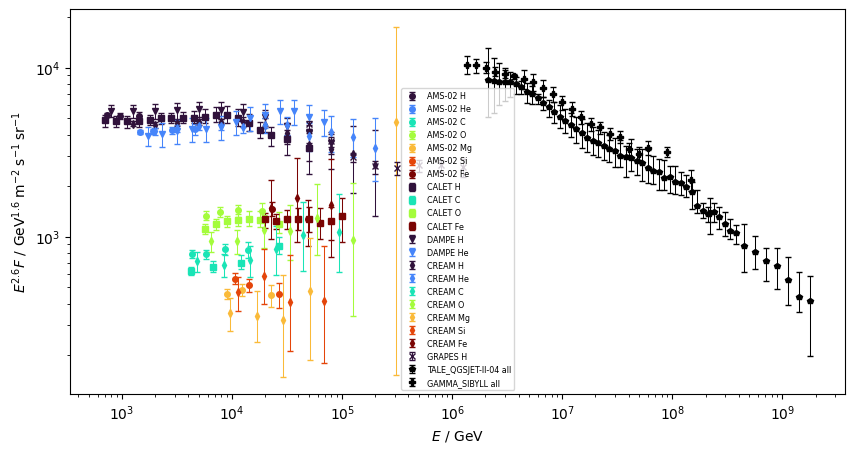

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

scale = 2.6
for _, particle_spectra in fit_data.spectra.items():
    for _, spectrum in particle_spectra.items():
        spectrum.plot(scale=scale, ax=ax)
for _, spectrum in fit_data.all_particle_spectra.items():
    spectrum.plot(scale=scale, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

In [4]:
from scipy import stats
from cr_knee_fit.cr_model import CosmicRaysModel, RigidityBreak, SharedPowerLaw
from cr_knee_fit.shifts import ExperimentEnergyScaleShifts


def initial_guess_model(config: ModelConfig) -> Model:
    return Model(
        cr_model=CosmicRaysModel(
            base_spectra=[
                (
                    SharedPowerLaw(
                        lgI_per_primary={
                            primary: stats.norm.rvs(loc=-4, scale=0.5) - 2.6 * np.log10(primary.Z)
                            for primary in component
                        },
                        alpha=stats.norm.rvs(loc=2.7, scale=0.1),
                    )
                )
                for component in config.cr_model_config.components
            ],
            breaks=[
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=4.2, scale=0.1),
                    d_alpha=stats.norm.rvs(loc=0.3, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(5), scale=0.01),
                ),
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=5.3, scale=0.1),
                    d_alpha=stats.norm.rvs(loc=-0.3, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(10), scale=0.01),
                ),
                RigidityBreak(
                    lg_R=stats.norm.rvs(loc=6.5, scale=0.2),
                    d_alpha=stats.norm.rvs(loc=-0.3, scale=0.05),
                    lg_sharpness=stats.norm.rvs(loc=np.log10(5), scale=0.01),
                ),
            ][: config.cr_model_config.n_breaks],
            all_particle_lg_shift=stats.norm.rvs(scale=0.2),
        ),
        energy_shifts=ExperimentEnergyScaleShifts(
            lg_shifts={exp: stats.norm.rvs(loc=0, scale=0.01) for exp in config.shifted_experiments}
        ),
    )

## Pre-optimization


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 105.83621532425735
             x: [-4.315e+00  2.750e+00 ... -1.336e-01 -4.690e-02]
           nit: 8400
          nfev: 10659
 final_simplex: (array([[-4.315e+00,  2.750e+00, ..., -1.336e-01,
                        -4.690e-02],
                       [-4.315e+00,  2.750e+00, ..., -1.336e-01,
                        -4.690e-02],
                       ...,
                       [-4.315e+00,  2.750e+00, ..., -1.336e-01,
                        -4.690e-02],
                       [-4.315e+00,  2.750e+00, ..., -1.336e-01,
                        -4.690e-02]]), array([ 1.058e+02,  1.058e+02, ...,  1.058e+02,  1.058e+02]))
  1.                          lgI_{H} = -4.32e+00
  2.                        alpha_{H} = 2.75e+00
  3.                         lgI_{He} = -5.19e+00
  4.                       alpha_{He} = 2.63e+00
  5.                          lgI_{C} = -7.18e+00
  6.          

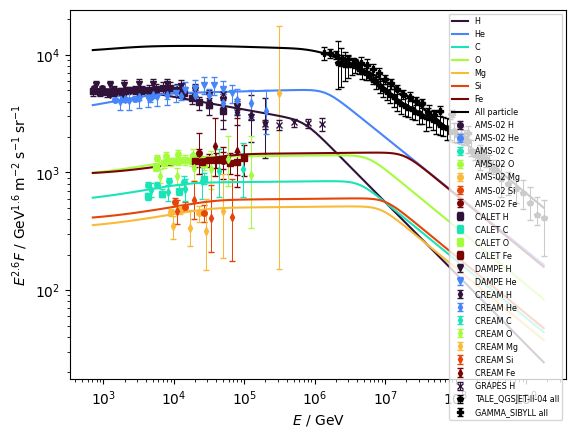

In [5]:


pre_optimization_config = dataclasses.replace(config, shifted_experiments={})
loglike = make_loglikelihood(fit_data, pre_optimization_config)


def minimized_fn(v: np.ndarray) -> float:
    return -loglike(v)


res = optimize.minimize(
    minimized_fn,
    x0=initial_guess_model(pre_optimization_config).pack(),
    method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
)
print(res)

mle_model = Model.unpack(res.x, layout_info=pre_optimization_config)
mle_model.plot(fit_data, scale=2.6)
mle_model.print_params()

In [6]:
init_model = initial_guess_model(config)

In [7]:
n_steps = 20_000
n_walkers = 128
n_dim = init_model.ndim()

sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=make_logposterior(fit_data, config),
)
initial_state = np.array([initial_guess_model(config).pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())

print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
print(f"MCMC sample ready, shape: {theta_sample.shape}")

  0%|          | 0/20000 [00:00<?, ?it/s]/home/njvh/Documents/Science/cr-knee-fit/.devenv/state/venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20000/20000 [58:57<00:00,  5.65it/s] 


Acceptance fraction: 0.17888437499999998


The chain is shorter than 50 times the integrated autocorrelation time for 26 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 897.8143042   945.89111934  816.78741938 1170.12804068  911.57719253
  856.86333034  836.08027642  841.57061526  762.4792302  1207.35702131
 1060.76667587  986.77043642  665.97741862 1123.15499182 1104.45772377
  712.81828459 1033.70537207 1251.46288942  895.5806329   726.4585669
 1090.77052376  632.89912389 1048.24535775  793.91350363  740.92088721
  666.32045313]


tau = array([ 897.8143042 ,  945.89111934,  816.78741938, 1170.12804068,
        911.57719253,  856.86333034,  836.08027642,  841.57061526,
        762.4792302 , 1207.35702131, 1060.76667587,  986.77043642,
        665.97741862, 1123.15499182, 1104.45772377,  712.81828459,
       1033.70537207, 1251.46288942,  895.5806329 ,  726.4585669 ,
       1090.77052376,  632.89912389, 1048.24535775,  793.91350363,
        740.92088721,  666.32045313])
burn_in = 6255 thin = 2502
MCMC sample ready, shape: (640, 26)


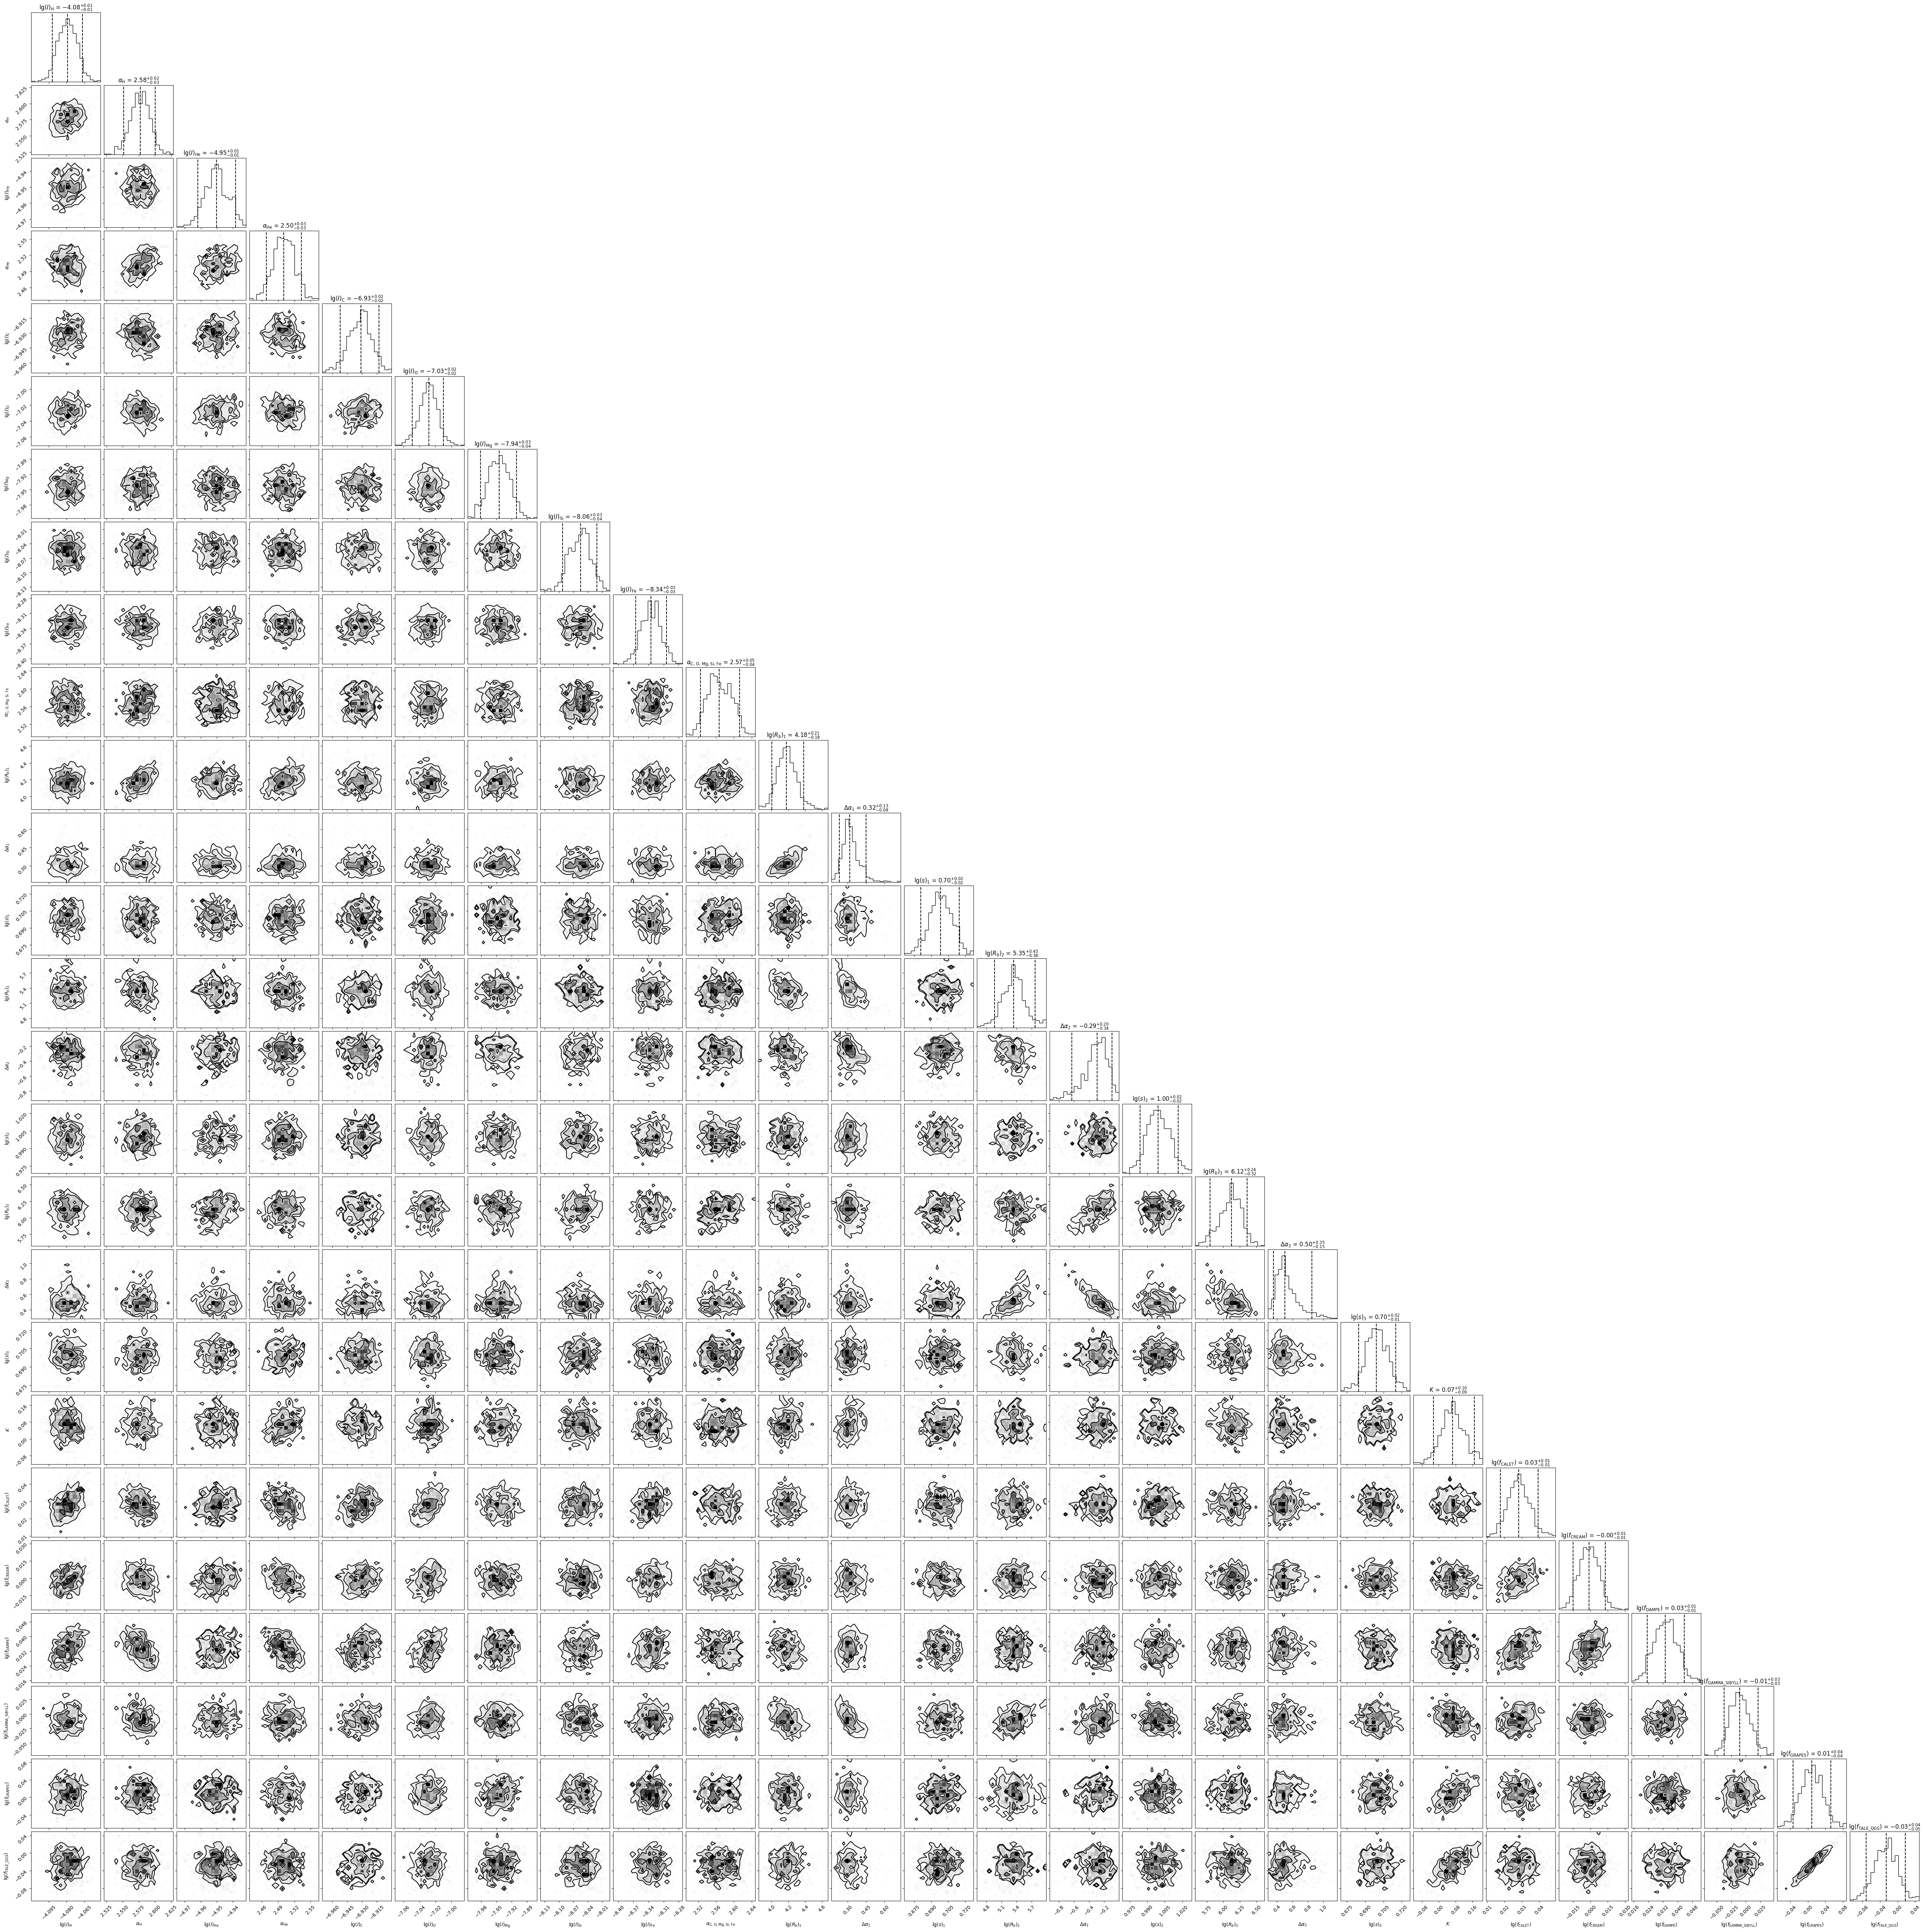

In [8]:

sample_to_plot = theta_sample
sample_labels = ["$" + label + "$" for label in init_model.labels(True)]

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    quantiles=[0.05, 0.5, 0.95],
)

  1.                          lgI_{H} = -4.08e+00
  2.                        alpha_{H} = 2.58e+00
  3.                         lgI_{He} = -4.95e+00
  4.                       alpha_{He} = 2.50e+00
  5.                          lgI_{C} = -6.93e+00
  6.                          lgI_{O} = -7.03e+00
  7.                         lgI_{Mg} = -7.94e+00
  8.                         lgI_{Si} = -8.06e+00
  9.                         lgI_{Fe} = -8.34e+00
 10.         alpha_{C, O, Mg, Si, Fe} = 2.57e+00
 11.                        lg(R_b)_1 = 4.18e+00
 12.                        d_alpha_1 = 3.16e-01
 13.                          lg(s)_1 = 6.98e-01
 14.                        lg(R_b)_2 = 5.35e+00
 15.                        d_alpha_2 = -2.91e-01
 16.                          lg(s)_2 = 9.99e-01
 17.                        lg(R_b)_3 = 6.12e+00
 18.                        d_alpha_3 = 5.01e-01
 19.                          lg(s)_3 = 6.99e-01
 20.                                K = 6.52e-02
 21.        

(np.float64(162.14682100669302), np.float64(7761289380.740025))

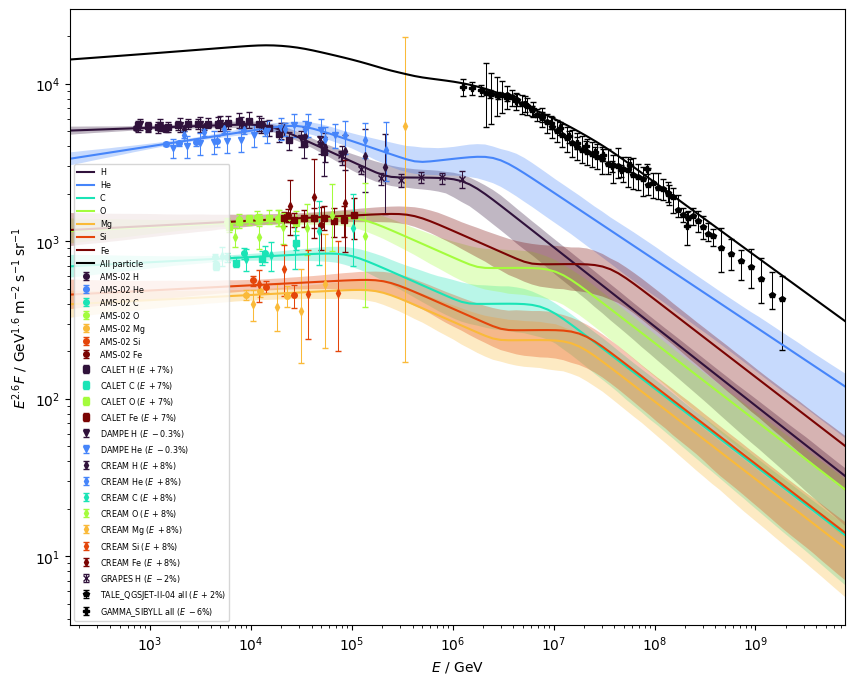

In [9]:
import itertools

from cr_knee_fit.utils import add_log_margin


scale = 2.6
model_sample = [Model.unpack(theta, layout_info=config) for theta in theta_sample]
median_model = Model.unpack(np.median(theta_sample, axis=0), layout_info=config)
median_model.print_params()

fig, ax = plt.subplots(figsize=(10, 8))

for exp, data_by_particle in fit_data.spectra.items():
    for _, spectrum in data_by_particle.items():
        spectrum.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(scale=scale, ax=ax)

for exp, spectrum in fit_data.all_particle_spectra.items():
    spectrum.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(scale=scale, ax=ax)

primaries = median_model.cr_model.layout_info().primaries
Emin, Emax = add_log_margin(fit_data.E_min(), fit_data.E_max())
median_model.cr_model.plot(Emin, Emax, scale=scale, axes=ax)

for p in primaries:
    primary_energies = list(
        itertools.chain.from_iterable(
            exp_spectra[p].E for exp_spectra in fit_data.spectra.values() if p in exp_spectra
        )
    )
    # Emin_p, Emax_p = add_log_margin(min(primary_energies), max(primary_energies))
    Emin_p = Emin
    Emax_p = Emax
    E_grid = np.logspace(np.log10(Emin_p), np.log10(Emax_p), 100)
    E_factor = E_grid**scale
    upper = []
    lower = []
    for E in E_grid:
        predictions = np.array([model.cr_model.compute(E, p) for model in model_sample])
        lower.append(np.quantile(predictions, q=0.05))
        upper.append(np.quantile(predictions, q=0.95))
    ax.fill_between(
        E_grid,
        E_factor * lower,
        E_factor * upper,
        color=p.color,
        alpha=0.3,
        edgecolor="none",
    )

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(Emin, Emax)
